<a href="https://colab.research.google.com/github/frferreira/Ifes-RedesNeurais/blob/main/ComparadorSeparadorLinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.datasets import load_iris

iris = load_iris()
Xtr, ytr = iris.data[:, :2], iris.target
Xtr, ytr

(array([[5.1, 3.5],
        [4.9, 3. ],
        [4.7, 3.2],
        [4.6, 3.1],
        [5. , 3.6],
        [5.4, 3.9],
        [4.6, 3.4],
        [5. , 3.4],
        [4.4, 2.9],
        [4.9, 3.1],
        [5.4, 3.7],
        [4.8, 3.4],
        [4.8, 3. ],
        [4.3, 3. ],
        [5.8, 4. ],
        [5.7, 4.4],
        [5.4, 3.9],
        [5.1, 3.5],
        [5.7, 3.8],
        [5.1, 3.8],
        [5.4, 3.4],
        [5.1, 3.7],
        [4.6, 3.6],
        [5.1, 3.3],
        [4.8, 3.4],
        [5. , 3. ],
        [5. , 3.4],
        [5.2, 3.5],
        [5.2, 3.4],
        [4.7, 3.2],
        [4.8, 3.1],
        [5.4, 3.4],
        [5.2, 4.1],
        [5.5, 4.2],
        [4.9, 3.1],
        [5. , 3.2],
        [5.5, 3.5],
        [4.9, 3.6],
        [4.4, 3. ],
        [5.1, 3.4],
        [5. , 3.5],
        [4.5, 2.3],
        [4.4, 3.2],
        [5. , 3.5],
        [5.1, 3.8],
        [4.8, 3. ],
        [5.1, 3.8],
        [4.6, 3.2],
        [5.3, 3.7],
        [5. , 3.3],


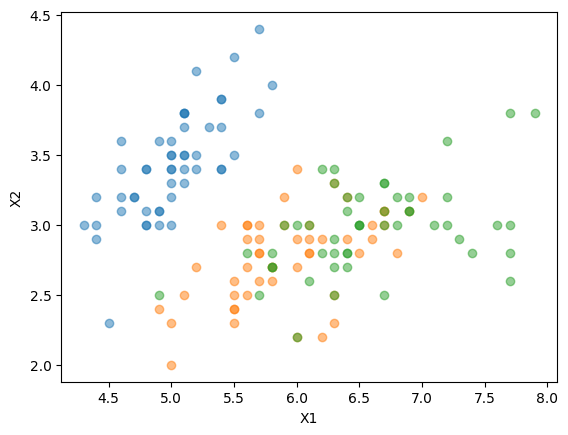

In [2]:
import matplotlib.pyplot as plt

def plotaDatasetBidimensional(X, y):
    """
    Plota um dataset bidimensional.
    """
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], "o", alpha=0.5)

plotaDatasetBidimensional(Xtr, ytr)

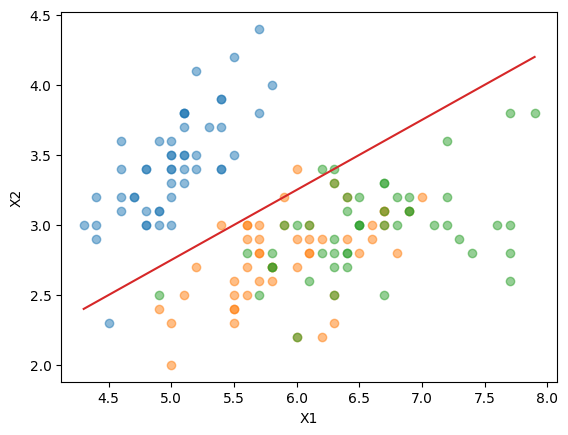

In [4]:
def plotaHiperplanoDatasetBidimensional(X, vetor, intercept=0):
    x0min = min(X[:,0])
    x0max = max(X[:,0])
    xs = np.linspace(x0min, x0max, num=2)
    ys = (-vetor[0] / vetor[1]) * xs - intercept / vetor[1]
    plt.plot(xs,ys)

plotaDatasetBidimensional(Xtr, ytr)
vetor_hyperplano = np.array([2, 4]) * np.array([1, -1])
plotaHiperplanoDatasetBidimensional(Xtr, vetor_hyperplano, 1)

In [5]:
def sign(a):
    return (a >= 0) * 2 - 1

def accuracy(yactual, ypred):
    return sum(yactual == ypred)/len(yactual)

In [6]:
from abc import ABC, abstractstaticmethod

class Custo(ABC):
    @abstractstaticmethod
    def custo(y, ypred):
        pass
    @abstractstaticmethod
    def gradiente(y, ypred, X):
        pass

class WidrowHoff(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum((1 - (y * ypred))**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - ypred)

class SmoothedSurrogate(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - sign(ypred))

class HingeLoss(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), 1 - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        errosmarginais = (y * ypred) < 1
        ymarginais = np.copy(y)
        ymarginais[~errosmarginais] = 0
        g = X.T @ ymarginais
        return g

from scipy.special import expit

class LogLikelihood(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.log(1 + np.exp(- y * ypred)))
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - (expit(ypred)*2-1))


In [7]:
from abc import ABC, abstractmethod

class TrainingAlgorithm(ABC):
  @abstractmethod
  def getW(self, X, y, activation):
    pass

class PseudoInversa(TrainingAlgorithm):
  def __init__(self, regularization=0):
    self.regularization = regularization
  def getW(self, X, y):
    return np.linalg.inv(X.T @ X + np.eye(X.shape[1])*self.regularization) @ X.T @ y


class DescidaGradiente(TrainingAlgorithm):
  def __init__(self, max_iter=100, learning_rate=0.05, 
               regularization=0, cost=WidrowHoff()):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.regularization = regularization
    self.cost = cost

  def getW(self, X, y):
    w = np.random.uniform(-1, 1, size=(X.shape[1], y.shape[1]))
    for _ in range(self.max_iter):
      ypred = X @ w
      if self.cost.custo(y, ypred) == 0:
        break
      w *= 1 - self.regularization * self.learning_rate
      w += self.cost.gradiente(y, ypred, X) * self.learning_rate
    return w

0.66
[[  11.64326353    3.41963495  -34.51052826]
 [ -45.81523966   20.346254     62.43525992]
 [  77.65536293 -110.73424515  -91.56139812]]


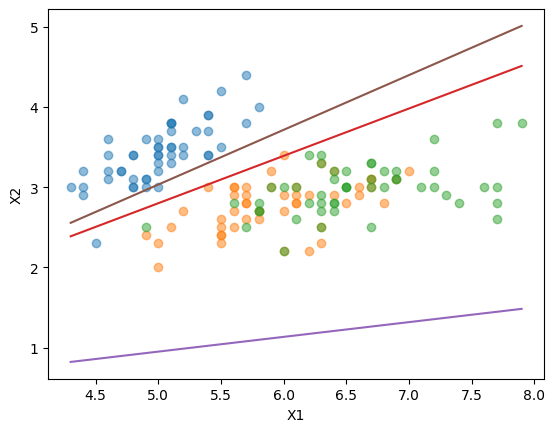

In [8]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

def include_bias(X):
  bias = np.ones((X.shape[0], 1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

class Perceptron(BaseEstimator, ClassifierMixin):
  def __init__(self, training_algorithm=DescidaGradiente()):
    self.w = None
    self.training_algorithm = training_algorithm

  def encode_labels(self, y):
    self.labels = list(set(y))
    return label_binarize(y, classes=self.labels)*2-1

  def fit(self, X, y):
    Xb = include_bias(X)
    yhot = self.encode_labels(y)
    self.w = self.training_algorithm.getW(Xb, yhot)

  def __pre_activation(self, X):
    Xb = include_bias(X)
    return Xb @ self.w

  def predict(self, X):
    a = self.__pre_activation(X)
    if self.w.shape[1] == 1:
      idx = np.array(a > 0, dtype=int).reshape((-1,))
    else:
      idx = np.argmax(a, axis=1)
    ypred = np.array([self.labels[i] for i in idx])
    return ypred

perceptron = Perceptron(training_algorithm=DescidaGradiente(cost=LogLikelihood()))
perceptron.fit(Xtr, ytr)
print(accuracy(ytr, perceptron.predict(Xtr)))
print(perceptron.w)
plotaDatasetBidimensional(Xtr, ytr)


if perceptron.w.shape[1] == 1:
  plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:], perceptron.w[0])
else:
  for i in range(perceptron.w.shape[1]):
    plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:,i], perceptron.w[0,i])

0.82


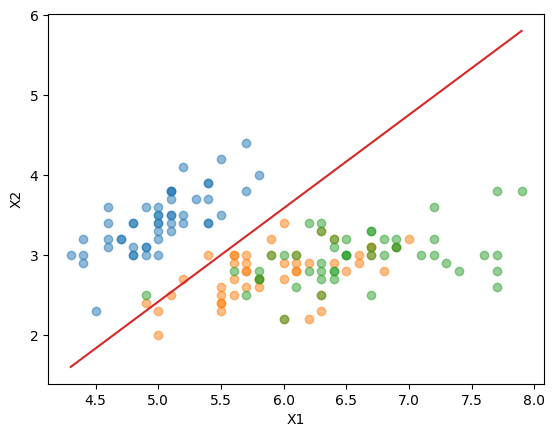

In [9]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression()
logReg.fit(Xtr, ytr)
y_pred = logReg.predict(Xtr)
print(accuracy(ytr, y_pred))
# Chame a função plotaDatasetBidimensional(Xtr, ytr) para plotar o conjunto de dados inicial
plotaDatasetBidimensional(Xtr, ytr)
# Chame a função plotaHiperplanoDatasetBidimensional(Xtr, vetor, intercept) para plotar o hiperplano
vetor = logReg.coef_[0]
intercept = logReg.intercept_[0]
plotaHiperplanoDatasetBidimensional(Xtr, vetor, intercept)
# Defina rótulos dos eixos
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

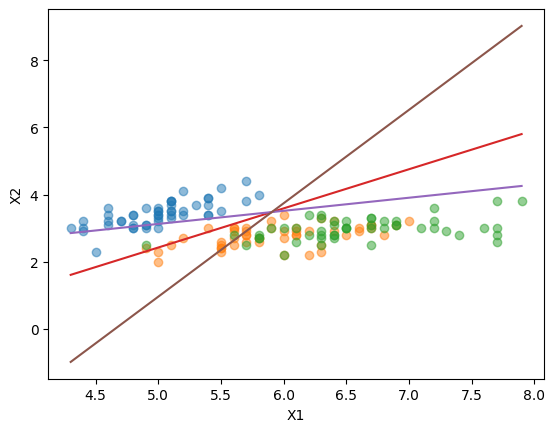

In [10]:

plotaDatasetBidimensional(Xtr, ytr)
for i in range(logReg.coef_.shape[0]):
    plotaHiperplanoDatasetBidimensional(Xtr, logReg.coef_[i], logReg.intercept_[i])
    # Defina rótulos dos eixos
    plt.xlabel('X1')
    plt.ylabel('X2')
plt.show()